### Related webs

* Download the dataset: Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

#### Import Library

In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

#### Hyper parameters Setting

In [2]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10 # How much to train a model

#### Set seed and Random Value

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

#### Load train, test data

In [4]:
train_dir = '../data/train'
test_dir = '../data/test'
os.listdir(train_dir)[:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

In [5]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
len(train_list), len(test_list)

(25000, 12500)

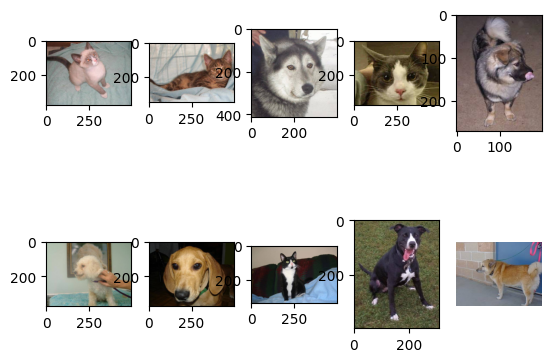

In [6]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)
fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [9]:
train_list[0].split('\\')[-1].split('.')[0]
int(test_list[0].split('\\')[-1].split('.')[0])

1

In [10]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

#### Image Augumentation

In [11]:
# data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [12]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform

    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [13]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [17]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
#check our images shape
train_data[0][0].shape

20000 200
5000 50


torch.Size([3, 224, 224])

#### Build Model

In [18]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [19]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [20]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

#### Train our Network

In [42]:
for batch_idx, (data, label) in enumerate(test_loader):
    #label = [l.split('\\')[-1] for l in label]
    print(f"Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}")
    print(f"Label shape: {label}")
    if batch_idx == 0:
        break

Batch 1:
Data shape: torch.Size([100, 3, 224, 224])
Label shape: ('test\\10034', 'test\\10582', 'test\\11524', 'test\\6527', 'test\\3676', 'test\\2337', 'test\\10339', 'test\\1662', 'test\\6098', 'test\\7210', 'test\\222', 'test\\6812', 'test\\9241', 'test\\6576', 'test\\11200', 'test\\5529', 'test\\8823', 'test\\1855', 'test\\9619', 'test\\4029', 'test\\723', 'test\\1661', 'test\\8455', 'test\\11349', 'test\\12168', 'test\\5736', 'test\\1822', 'test\\11399', 'test\\261', 'test\\6904', 'test\\384', 'test\\10333', 'test\\5988', 'test\\3042', 'test\\11507', 'test\\8335', 'test\\3455', 'test\\3398', 'test\\9415', 'test\\10623', 'test\\9543', 'test\\98', 'test\\3559', 'test\\1247', 'test\\464', 'test\\4020', 'test\\6562', 'test\\4231', 'test\\1701', 'test\\5924', 'test\\12467', 'test\\995', 'test\\5388', 'test\\1396', 'test\\5975', 'test\\5271', 'test\\1538', 'test\\3674', 'test\\8353', 'test\\82', 'test\\9468', 'test\\8609', 'test\\10567', 'test\\8618', 'test\\11216', 'test\\7527', 'test\

In [54]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        class_names = [l.split('\\')[-1] for l in label]
        class_to_label = {'dog': 0, 'cat': 1}
        label_list = [class_to_label[class_name] for class_name in class_names]
        label = torch.tensor(label_list, dtype=torch.long).to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            class_names = [l.split('\\')[-1] for l in label]
            class_to_label = {'dog': 0, 'cat': 1}
            label_list = [class_to_label[class_name] for class_name in class_names]
            label = torch.tensor(label_list, dtype=torch.long).to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
        

Epoch : 1, train accuracy : 0.6901503801345825, train loss : 0.58107590675354
Epoch : 1, val_accuracy : 0.7302000522613525, val_loss : 0.5355222225189209
Epoch : 2, train accuracy : 0.7105998992919922, train loss : 0.5557664036750793
Epoch : 2, val_accuracy : 0.7178001403808594, val_loss : 0.5477022528648376
Epoch : 3, train accuracy : 0.7246500253677368, train loss : 0.5372709631919861
Epoch : 3, val_accuracy : 0.7380000352859497, val_loss : 0.518560528755188
Epoch : 4, train accuracy : 0.7325003743171692, train loss : 0.5230968594551086
Epoch : 4, val_accuracy : 0.7429999113082886, val_loss : 0.5159422159194946
Epoch : 5, train accuracy : 0.7417002320289612, train loss : 0.5112828612327576
Epoch : 5, val_accuracy : 0.734000027179718, val_loss : 0.5258237719535828
Epoch : 6, train accuracy : 0.7471999526023865, train loss : 0.5048328638076782
Epoch : 6, val_accuracy : 0.7485998868942261, val_loss : 0.5057291388511658
Epoch : 7, train accuracy : 0.7456502318382263, train loss : 0.50469

In [55]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        fileid = [fi.split('\\')[-1] for fi in fileid]
        dog_probs += list(zip(fileid, preds_list))

In [56]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs[:5]

[('1', 0.15609462559223175),
 ('2', 0.02612248808145523),
 ('3', 0.12512768805027008),
 ('4', 0.1599913388490677),
 ('5', 0.8823323249816895)]

In [57]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
# submission.to_csv('result.csv',index=False)
submission[:5]

,id,label
0,1,0.156095
1,2,0.026122
2,3,0.125128
3,4,0.159991
4,5,0.882332


#### check our model performance and visualize some data!

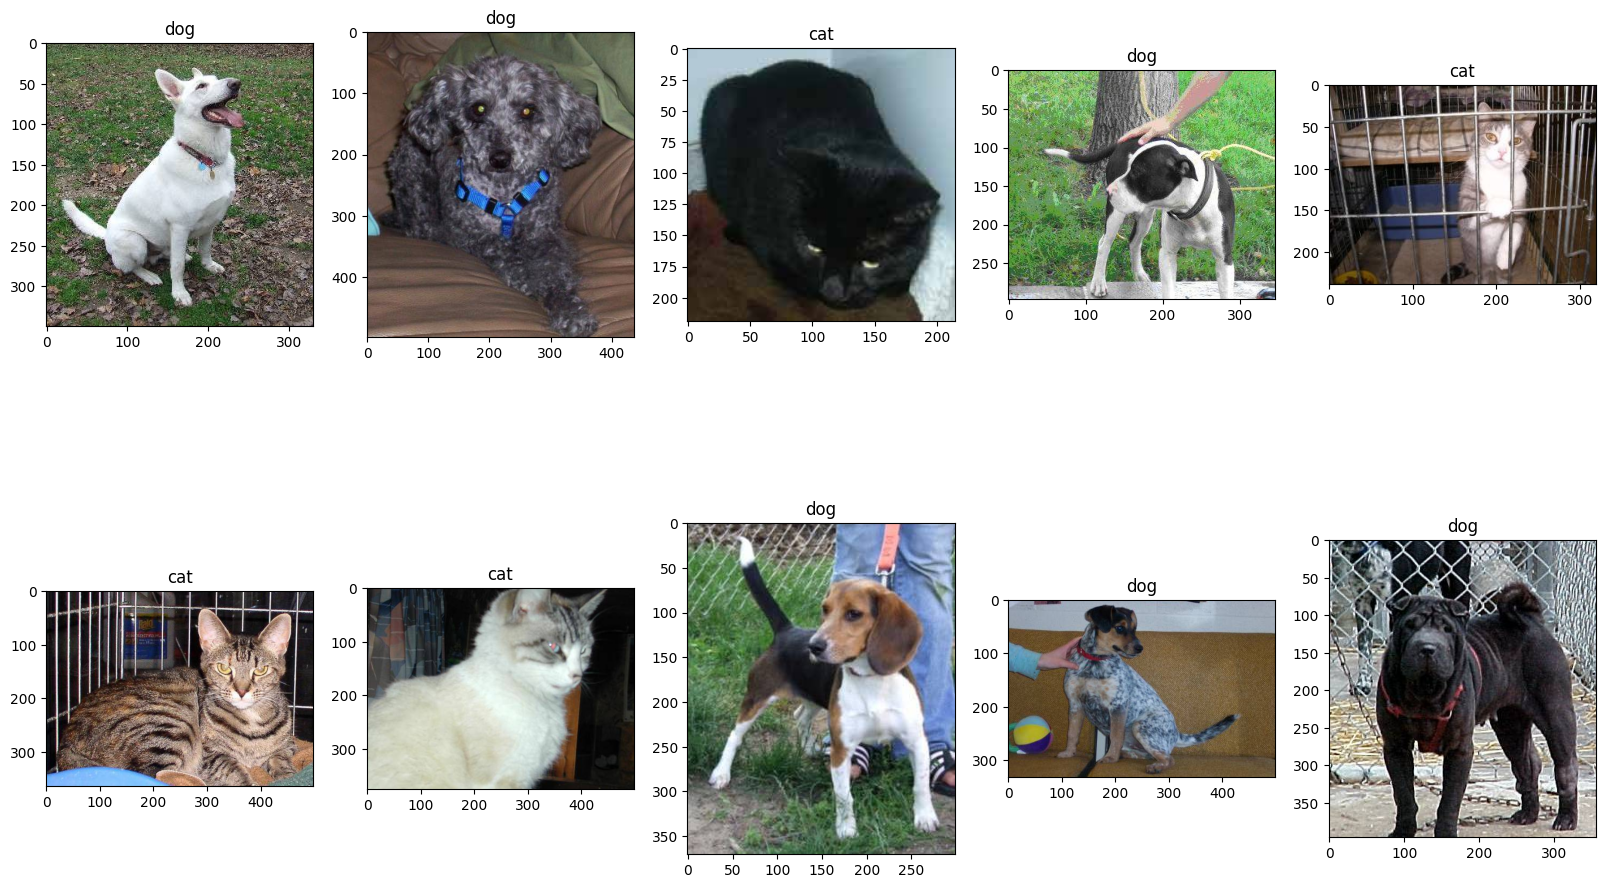

In [58]:
import random

id_list = []
class_ = {0: 'dog', 1: 'cat'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)